# Correlation Analysis

Several previous appoaches have used transcriptomics for drug mechanism of action deconvolution and drug repositioning.

[Iorio et al., (2010)](https://doi.org/10.1073/pnas.1000138107) and later [Emon et al., (2020)](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-020-03568-5#ref-CR15) suggested using expert-curated pathway databases as a means of dimensionality reduction.

This notebook demonstrates doing this in practice using differential gene expression profiles curated in the [CREEDS database](https://maayanlab.cloud/CREEDS) based on drug perturbations, gene knockouts, gene overexpressions, and diseases.

Notably, it uses [PyBioPAX](https://github.com/indralab/pybiopax) to acquire and process [Reactome](https://reactome.org/) as an example pathway database.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import itertools as itt
from sklearn.feature_selection import VarianceThreshold
import pystow
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import numpy as np
from scipy.stats import pearsonr
from pyobo.sources import reactome

CREEDS = pystow.module("bio", "creeds")
CHEMICAL = CREEDS.join(name="chemical.tsv")
DISEASE = CREEDS.join(name="disease.tsv")
GENE = CREEDS.join(name="gene.tsv")

## Load Data

The analysis itself has been carried out by running `python -m pybiopax.analysis.creeds_analysis` which stores the results in a consistent location using [`pystow`](https://github.com/cthoyt/pystow). This code automatically acquires all data dependencies and should be runnable on any system.

In [2]:
gene_df = pd.read_csv(GENE, sep='\t')
gene_df.head()

,perturbation,pathway,p,q,mlq
0,hgnc:3791,reactome:R-HSA-392499,3.563415e-74,9.072454e-71,70.042275
1,hgnc:3791,reactome:R-HSA-8953854,8.163782e-67,6.928330e-64,63.159371
2,hgnc:3791,reactome:R-HSA-8953897,7.054626e-67,6.928330e-64,63.159371
3,hgnc:3791,reactome:R-HSA-2262752,1.441503e-66,9.175168e-64,63.037386
4,hgnc:3791,reactome:R-HSA-5663205,3.018265e-53,1.536900e-50,49.813354


In [3]:
chemical_df = pd.read_csv(CHEMICAL, sep='\t')
chemical_df.head()

,perturbation,pathway,p,q,mlq
0,pubchem.compound:445154,reactome:R-HSA-168256,1.345600e-164,3.425898e-161,160.465226
1,pubchem.compound:445154,reactome:R-HSA-1430728,5.476500e-158,6.971584e-155,154.156669
2,pubchem.compound:445154,reactome:R-HSA-392499,6.337993e-129,5.378843e-126,125.269311
3,pubchem.compound:445154,reactome:R-HSA-8953897,5.270683e-116,3.354790e-113,112.474335
4,pubchem.compound:445154,reactome:R-HSA-1643685,2.402538e-115,1.223372e-112,111.912441


In [4]:
disease_df = pd.read_csv(DISEASE, sep='\t')
disease_df.head()

,perturbation,pathway,p,q,mlq
0,doid:DOID:12930,reactome:R-HSA-1430728,7.155170e-132,1.821706e-128,127.739522
1,doid:DOID:12930,reactome:R-HSA-8953897,2.820769e-79,3.590839e-76,75.444804
2,doid:DOID:12930,reactome:R-HSA-2262752,1.730824e-75,1.468893e-72,71.833010
3,doid:DOID:12930,reactome:R-HSA-156842,1.658557e-71,1.055672e-68,67.976471
4,doid:DOID:12930,reactome:R-HSA-392499,4.061869e-71,2.068304e-68,67.684386


## Pathway Size Filter

Pathways that are either too big or too small don't give very useful p-values in the hypergeometric test

In [5]:
participants_df = reactome.ensure_participant_df(version="78")
participants_df.columns = ["uniprot_id", "reactome_id"]
idx = participants_df.groupby("reactome_id").count()["uniprot_id"]

# Make a list of pathways that are neither too big nor small
valid_size = {f"reactome:{k}" for k,v in ((5 < idx) & (idx < 250)).items() if v}

In [6]:
gene_df = gene_df[gene_df["pathway"].isin(valid_size)]
chemical_df = chemical_df[chemical_df["pathway"].isin(valid_size)]
disease_df = disease_df[disease_df["pathway"].isin(valid_size)]

## Feature Preprocessing

Right now we're going to use a min-max normalized version of the minus-log-<i>q</i> value as the feature for each gene-pathway and chemical-pathway pair.

In [7]:
def minmax(x):
    return (x- x.min()) / (x.max() - x.min())

gene_df["feature"]     = minmax(-np.log10(gene_df["p"]))
chemical_df["feature"] = minmax(-np.log10(chemical_df["p"]))
disease_df["feature"]  = minmax(-np.log10(disease_df["p"]))

# Dataframe Reshaping


In [8]:
gene_square_df = gene_df.pivot(index="perturbation", columns="pathway")["feature"]
gene_square_df.shape

(466, 1794)

In [9]:
chem_square_df = chemical_df.pivot(index="perturbation", columns="pathway")["feature"]
chem_square_df.shape

(148, 1794)

In [10]:
disease_square_df = disease_df.pivot(index="perturbation", columns="pathway")["feature"]
disease_square_df.shape

(178, 1794)

## Investivate the Variance of features in both datasets

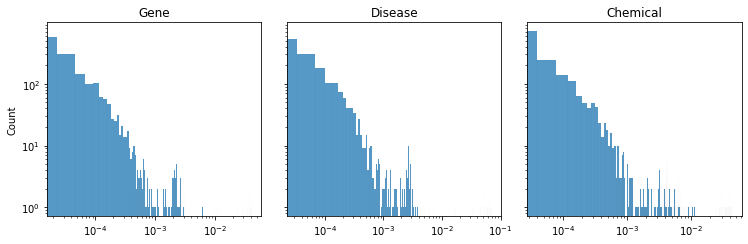

In [11]:
fig, (lax, miax, rax) = plt.subplots(1, 3, figsize=(10.5, 3.5), sharey=True)

sns.histplot(gene_square_df.var().values, ax=lax)
lax.set_yscale("log")
lax.set_xscale("log")
lax.set_title("Gene")

sns.histplot(disease_square_df.var().values, ax=miax)
miax.set_yscale("log")
miax.set_xscale("log")
miax.set_title("Disease")

sns.histplot(chem_square_df.var().values, ax=rax)
rax.set_yscale("log")
rax.set_xscale("log")
rax.set_title("Chemical")

plt.tight_layout()
plt.show()

In [12]:
MIN_VAR = 2.5e-3

var_series = (
    (MIN_VAR < gene_square_df.var()) 
    & (MIN_VAR < chem_square_df.var())
    & (MIN_VAR < disease_square_df.var())
)
var_idx = [k for k,v in var_series.items() if v]
print(f"keeping {var_series.sum()} features with more than {MIN_VAR} in both datasets")

chem_square_df    = chem_square_df[var_idx]
gene_square_df    = gene_square_df[var_idx]
disease_square_df = disease_square_df[var_idx]

keeping 62 features with more than 0.0025 in both datasets


In [13]:
# Check comparisons are going to make sense
(chem_square_df.columns == gene_square_df.columns).all()

True

In [14]:
(disease_square_df.columns == gene_square_df.columns).all()

True

## Make Comparison

This comparison is based on the Pearson R.

In [15]:
def comp(df1, df2):
    # Do all by all comparison
    rows = [
        [
            pearsonr(df1_values, df2_values)[0]
            for _, df2_values in df2.iterrows()
        ]
        for _, df1_values in tqdm(df1.iterrows(), total=len(df1))

    ]
    return pd.DataFrame(rows, index=df1.index, columns=df2.index)

chem_gene_df = comp(chem_square_df, gene_square_df)
chem_dis_df = comp(chem_square_df, disease_square_df)
gene_dis_df = comp(gene_square_df, disease_square_df)

  0%|          | 0/148 [00:00<?, ?it/s]

/Users/cthoyt/.virtualenvs/indra/lib/python3.9/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/466 [00:00<?, ?it/s]

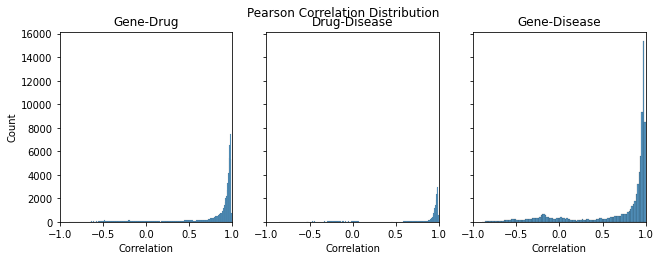

In [16]:
fig, (lax, miax, rax) = plt.subplots(1, 3, figsize=(10.5, 3.5), sharey=True)

sns.histplot(chem_gene_df.values.ravel(), ax=lax)
lax.set_title("Gene-Drug")
lax.set_xlabel("Correlation")
lax.set_xlim([-1, 1])

sns.histplot(chem_dis_df.values.ravel(), ax=miax)
miax.set_title("Drug-Disease")
miax.set_xlabel("Correlation")
miax.set_xlim([-1, 1])

sns.histplot(gene_dis_df.values.ravel(), ax=rax)
rax.set_title("Gene-Disease")
rax.set_xlabel("Correlation")
rax.set_xlim([-1, 1])

plt.suptitle("Pearson Correlation Distribution")
plt.show()

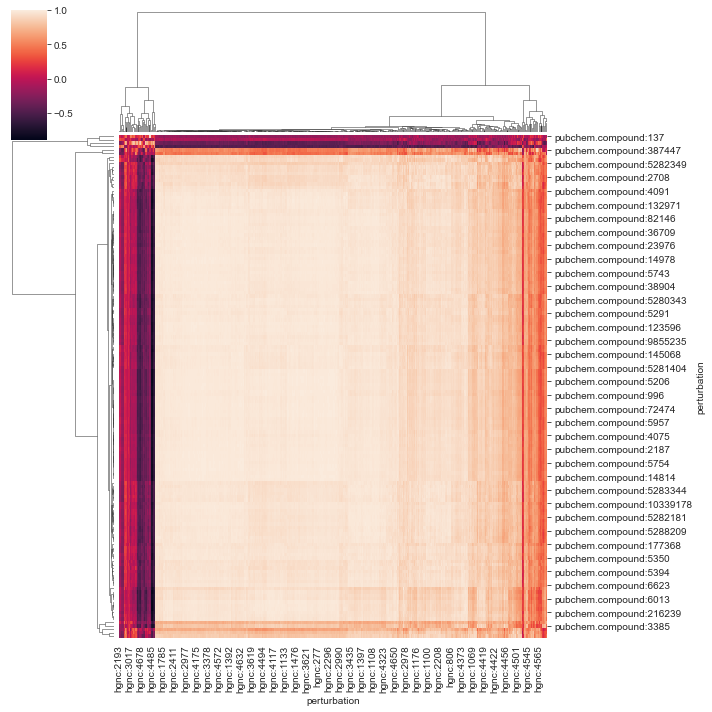

In [17]:
sns.set_style("white")
g = sns.clustermap(chem_gene_df.fillna(0.0))
g.savefig("/Users/cthoyt/Desktop/creeds.png")